In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
msl_df = pd.read_csv("input_data/msl_clean.csv")
print(len(msl_df))
msl_df.head()

13837


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [3]:
vecs_mols = torch.load("torch_data/mol_embs.pt", map_location="cpu")
print(vecs_mols.shape)

vecs_sols = torch.load("torch_data/sol_embs.pt", map_location="cpu")
print(vecs_sols.shape)

torch.Size([13837, 256])
torch.Size([13837, 256])


C:\Users\kappa\AppData\Local\Temp\ipykernel_4036\897032716.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vecs_mols = torch.load("torch_data/mol_embs.pt", map_location=

In [14]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def mol_descs(smile):
    mol = Chem.MolFromSmiles(smile)
    descs = []
    for dname, func in Descriptors._descList:
        descs.append(func(mol))
    return descs

In [31]:
desc_df = []
for idx, smile in enumerate(msl_df['Chromophore']):
    vals = mol_descs(smile)
    desc_df.append(vals)
    print(idx+1)

desc_df = pd.DataFrame(desc_df)
print(len(desc_df))
desc_df.head()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,11.683581,11.683581,0.021944,-1.306869,0.524072,11.040000,330.295,320.215,330.053921,122,...,0,0,0,0,0,0,0,0,0,0
1,12.335178,12.335178,0.247484,-1.130887,0.405433,18.864865,490.603,460.363,490.225643,186,...,0,0,0,0,0,0,0,0,0,0
2,12.408729,12.408729,0.029454,-1.347366,0.284676,11.310345,645.879,639.831,641.695969,146,...,0,0,0,0,0,0,0,0,0,0
3,12.503623,12.503623,0.021975,-1.307991,0.220631,11.310345,833.879,827.831,833.640512,146,...,0,0,0,0,0,0,0,0,0,0
4,12.637713,12.637713,0.057996,-1.632189,0.093205,11.515152,971.659,969.643,969.484623,170,...,0,0,0,0,0,0,0,0,0,0


In [32]:
desc_df = desc_df.fillna(desc_df.mean())
print(len(desc_df))
desc_df.head()

13837


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,216
0,11.683581,11.683581,0.021944,-1.306869,0.524072,11.040000,330.295,320.215,330.053921,122,...,0,0,0,0,0,0,0,0,0,0
1,12.335178,12.335178,0.247484,-1.130887,0.405433,18.864865,490.603,460.363,490.225643,186,...,0,0,0,0,0,0,0,0,0,0
2,12.408729,12.408729,0.029454,-1.347366,0.284676,11.310345,645.879,639.831,641.695969,146,...,0,0,0,0,0,0,0,0,0,0
3,12.503623,12.503623,0.021975,-1.307991,0.220631,11.310345,833.879,827.831,833.640512,146,...,0,0,0,0,0,0,0,0,0,0
4,12.637713,12.637713,0.057996,-1.632189,0.093205,11.515152,971.659,969.643,969.484623,170,...,0,0,0,0,0,0,0,0,0,0


In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
desc_scale = scaler.fit_transform(desc_df.values)

desc_tensor = torch.tensor(desc_scale, dtype=torch.float32).to(vecs_mols.device)

In [34]:
X = torch.cat([vecs_mols, vecs_sols, desc_tensor], dim=1)
print(X.shape)

torch.Size([13837, 729])


In [35]:
y = torch.tensor(msl_df['Quantum yield'].values)
print(y.shape)

torch.Size([13837])


In [36]:
import numpy as np
from sklearn.model_selection import train_test_split

X_np = X.cpu().numpy()
y_np = y.cpu().numpy()

X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11069, 729) (2768, 729) (11069,) (2768,)


In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128, 64),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=2000,
    warm_start=True,
    random_state=42
)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print(f"R Squared: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

R Squared: 0.637
RMSE: 0.185


In [38]:
xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=4,
    reg_lambda=2.0,
    reg_alpha=0.2,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50,
    tree_method="hist"
)

eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print(f"R Squared: {r2_score(y_test, y_pred_xgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.3f}")

R Squared: 0.678
RMSE: 0.174


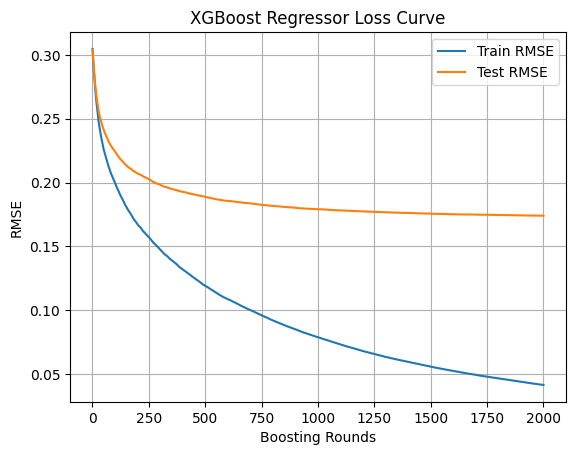

In [40]:
results = xgb_model.evals_result()
epochs = range(1, len(results['validation_0']['rmse']) + 1)

fig, ax = plt.subplots()
ax.plot(epochs, results['validation_0']['rmse'], label='Train RMSE')
ax.plot(epochs, results['validation_1']['rmse'], label='Test RMSE')
ax.legend()

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('XGBoost Regressor Loss Curve')
plt.grid(True)
plt.show()

In [ ]:
lgb_model = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1)

eval_set = [(X_train, y_train), (X_test, y_test)]

lgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", callbacks=[lgb.early_stopping(stopping_rounds=50)])

y_pred_lgb = lgb_model.predict(X_test)
print(f"R Squared: {r2_score(y_test, y_pred_lgb):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lgb)):.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147720
[LightGBM] [Info] Number of data points in the train set: 11069, number of used features: 707
[LightGBM] [Info] Start training from score 0.347005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[790]	training's rmse: 0.0375423	training's l2: 0.00140942	valid_1's rmse: 0.175097	valid_1's l2: 0.0306591
R Squared: 0.674
RMSE: 0.175


c:\Users\kappa\OneDrive\Documents\GitHub\COATI\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


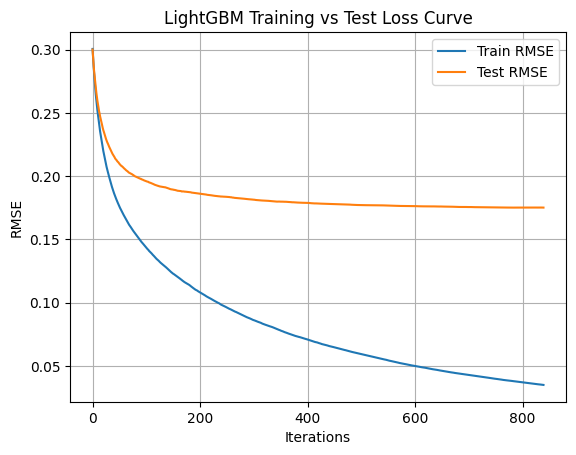

In [42]:
results_lgb = lgb_model.evals_result_

train_rmse = results_lgb['training']['rmse']
test_rmse = results_lgb['valid_1']['rmse']

plt.plot(train_rmse, label="Train RMSE")
plt.plot(test_rmse, label="Test RMSE")
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.title("LightGBM Training vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

## **Adding New Molecule/Solvent Data**

In [27]:
new_df = pd.read_csv('input_data\Machine Learning article database _ Alldata_SMILES_v0.1.xlsx - Sheet1.csv')
print(len(new_df))
new_df.head()

4386


,Unnamed: 0,Absorption/nm,Emission/nm,PLQY,SMILES,solvent,Reference(doi),Et30,SP,SdP,SA,SB,"Test method of Quantum Yield (0= measured by relative method/not mention in origin paper, 1= absolute QY)",Unnamed: 13
0,1,355.0,427.0,0.390,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=CN2C=C1,DMSO,10.1021ja204016e_0306,45.1,0.83,1.0,0.072,0.647,0.0,Figure 2 Quantum yields were measured using fl...
1,2,426.0,520.0,0.430,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=C(N2C=C1)N,DMSO,10.1021ja204016e_0306,45.1,0.83,1.0,0.072,0.647,0.0,NaN
2,3,387.0,528.0,0.490,O=C(C1=CC2=NC(C3=CC=C(OC)C=C3)=C(NC4CCCCC4)N2C...,DMSO,10.1021ja204016e_0306,45.1,0.83,1.0,0.072,0.647,0.0,NaN
3,4,355.0,627.0,0.002,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C(C(OC)=O)=CC=...,DMSO,10.1021ja204016e_0306,45.1,0.83,1.0,0.072,0.647,0.0,NaN
4,5,365.0,560.0,0.009,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C=CC=N4)C4=N2,DMSO,10.1021ja204016e_0306,45.1,0.83,1.0,0.072,0.647,0.0,NaN


In [28]:
new_sub_df = new_df[['SMILES', 'solvent', 'PLQY']]
new_sub_df.columns = ['Chromophore', 'Solvent', 'Quantum yield']
new_sub_df.head()

,Chromophore,Solvent,Quantum yield
0,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=CN2C=C1,DMSO,0.390
1,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=C(N2C=C1)N,DMSO,0.430
2,O=C(C1=CC2=NC(C3=CC=C(OC)C=C3)=C(NC4CCCCC4)N2C...,DMSO,0.490
3,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C(C(OC)=O)=CC=...,DMSO,0.002
4,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C=CC=N4)C4=N2,DMSO,0.009


In [31]:
unique_df = pd.read_csv('input_data/unique_solvents w smile strings - unique_solvents.csv')
print(unique_df.columns)

unique_df.head()

Index(['Molecules', 'SMILES'], dtype='object')


,Molecules,SMILES
0,1-Butanol,CCCCO
1,Ethylene glycol,OCCO
2,cyclohexane,C1CCCCC1
3,Diisopropyl ether,CC(C)OC(C)C
4,1-Hexanol,CCCCCCO


In [32]:
name_list = list(unique_df['Molecules'])
smiles_list = list(unique_df['SMILES'])

for name, sol1 in zip(name_list, smiles_list):
    new_sub_df.loc[new_sub_df['Solvent'] == name, 'Solvent'] = sol1
            
new_sub_df.head()

,Chromophore,Solvent,Quantum yield
0,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=CN2C=C1,CS(C)=O,0.390
1,O=C(OC)C1=CC2=NC(C3=CC=C(C=C3)OC)=C(N2C=C1)N,CS(C)=O,0.430
2,O=C(C1=CC2=NC(C3=CC=C(OC)C=C3)=C(NC4CCCCC4)N2C...,CS(C)=O,0.490
3,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C(C(OC)=O)=CC=...,CS(C)=O,0.002
4,COC1=CC=C(C=C1)C2=C(NC3CCCCC3)N(C=CC=N4)C4=N2,CS(C)=O,0.009


In [33]:
new_sub_df.to_csv('input_data/msl_2.csv', index=False)

In [34]:
new_sub_df = pd.read_csv('input_data/msl_2.csv')

In [35]:
msl_new = pd.concat([msl_df, new_sub_df], ignore_index=True)
print(len(msl_new))
msl_new.head

18223


<bound method NDFrame.head of                                              Chromophore    Solvent  \
0      O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12          O   
1      O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...         CO   
2      O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...          O   
3      O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...          O   
4      O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...          O   
...                                                  ...        ...   
18218  O=C1N(C2=C(C)C=CC=C2C)C(C3=CC(C4=C(N5)C=C(OC)C...      CC#N    
18219  O=C1N(C2=C(C)C=CC=C2C)C(C3=CC(C4=C(N5)C=C(OC)C...    CS(C)=O   
18220  O=C1N(C2=C(C)C=CC=C2C)C(C3=CC(C4=C(O5)C=C(OC)C...  Cc1ccccc1   
18221  O=C1N(C2=C(C)C=CC=C2C)C(C3=CC(C4=C(O5)C=C(OC)C...      CC#N    
18222  O=C1N(C2=C(C)C=CC=C2C)C(C3=CC(C4=C(O5)C=C(OC)C...    CS(C)=O   

       Quantum yield  
0              0.950  
1              1.000  
2              0.200  
3              0.020  
4 

In [36]:
msl_new = msl_new.drop_duplicates(subset=['Chromophore', 'Solvent'])
msl_new = msl_new.dropna()
print(len(msl_new))
msl_new.head()

16648


,Chromophore,Solvent,Quantum yield
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,0.950
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,1.000
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,0.200
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.020
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.018


In [37]:
import torch
from coati.models.io import load_e3gnn_smiles_clip_e2e

encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/grande_closed.pkl",
)

Loading model from s3://terray-public/models/grande_closed.pkl
Loading tokenizer may_closedparen from s3://terray-public/models/grande_closed.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 17.92M Total: 20.36M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
20561664 params frozen!


In [38]:
msl_new.to_csv('input_data/msl_new.csv', index=False)

In [47]:
from coati.generative.coati_purifications import embed_smiles

vecs_mols_new = []   

for idx, smile in enumerate(msl_new['Chromophore']):
    frag_vecs = []
    if '.' in smile:
        fragments = smile.split('.')
        for frag in fragments:
            vec = embed_smiles(frag, encoder, tokenizer)
            frag_vecs.append(vec)
        
        if len(frag_vecs) > 0:
            fused_emb = torch.mean(torch.stack(frag_vecs), dim=0)
            vecs_mols_new.append(fused_emb)
    else:
        vec = embed_smiles(smile, encoder, tokenizer)
        vecs_mols_new.append(vec)

    print(idx+1)

print(len(vecs_mols_new))
vecs_mols_new = torch.stack(vecs_mols_new)
print(vecs_mols_new.shape)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [48]:
torch.cuda.empty_cache()

vecs_mols_new = vecs_mols_new.to("cpu")
torch.save(vecs_mols_new, "torch_data/mols_new.pt")

In [44]:
from coati.generative.coati_purifications import embed_smiles

vecs_sols_new = []

for idx, sol in enumerate(msl_new['Solvent']):
    frag_vecs = []
    if ',' in sol:
        fragments = sol.split(',')
        for frag in fragments:
            vec = embed_smiles(frag, encoder, tokenizer)
            frag_vecs.append(vec)
        
        if len(frag_vecs) > 0:
            fused_emb = torch.mean(torch.stack(frag_vecs), dim=0)
            vecs_sols_new.append(fused_emb)
    else:
        vec = embed_smiles(sol, encoder, tokenizer)
        vecs_sols_new.append(vec)

    print(sol, idx+1)

print(len(vecs_sols_new))
vecs_sols_new = torch.stack(vecs_sols_new)
print(vecs_sols_new.shape)

O 1
CO 2
O 3
O 4
O 5
CO 6
CO 7
CO 8
CCO 9
CCO 10
CCO 11
CC(C)O 12
CC(C)O 13
CC(C)O 14
C1CCCCC1 15
C1CCCCC1 16
C1CCCCC1 17
C1CCCCC1 18
C1CCCCC1 19
C1CCCCC1 20
Cc1ccccc1 21
Cc1ccccc1 22
Cc1ccccc1 23
Cc1ccccc1 24
Cc1ccccc1 25
CCCCCC 26
C1COCCO1 27
CCO 28
CC#N 29
ClCCl 30
ClCCl 31
ClCCl 32
ClCCl 33
ClCCl 34
ClCCl 35
Cc1ccccc1 36
Cc1ccccc1 37
O 38
CC#N 39
CCO 40
OCC(O)CO 41
CC#N 42
CC#N 43
CC#N 44
CC#N 45
CC#N 46
CC#N 47
CCO 48
CCO 49
CCO 50
CCO 51
CCCCCC 52
Cc1ccccc1 53
ClCCl 54
C1CCOC1 55
CCCCCC 56
Cc1ccccc1 57
ClCCl 58
C1CCOC1 59
CCCCCC 60
Cc1ccccc1 61
ClCCl 62
C1CCOC1 63
CCCCCC 64
Cc1ccccc1 65
ClCCl 66
C1CCOC1 67
ClC(Cl)(Cl)Cl 68
CS(C)=O 69
O 70
C1CCCCC1 71
O 72
CO 73
C1CCCCC1 74
ClC(Cl)(Cl)Cl 75
CCCCOCCCC 76
CCOCC 77
CCCC#N 78
CN(C)C=O 79
CC1COC(=O)O1 80
CCCCCCCCCCO 81
CC(C)O 82
CCCCCO 83
CCCCO 84
CCCO 85
OCCO 86
OCC(O)CO 87
OCC(F)(F)F 88
OC(C(F)(F)F)C(F)(F)F 89
CCCCOC(C)=O 90
c1ccccc1 91
C1COCCO1 92
C1CCOC1 93
CC(C)=O 94
CC#N 95
CC(C)O 96
CO 97
OCCO 98
CC#N 99
CC(C)O 100
CCO 101
CO 10

In [45]:
torch.cuda.empty_cache()

vecs_sols_new = vecs_sols_new.to("cpu")
torch.save(vecs_sols_new, "torch_data/sols_new.pt")

In [46]:
msl_new.to_csv('input_data/msl_new.csv', index=False)